In [870]:
from No_sync.Frost_api import client_id, client_secret
import requests
import pandas as pd
from datetime import datetime, timedelta

<h2>API Call</h2>

In [871]:
# SN65320, SN65310, SN65370 
# Closest station gave error, so I used the second closest station
# air_temperature, precipitation_amount, wind_speed, relative_humidity, 

In [872]:
# Define the endpoint and parameters
endpoint = 'https://frost.met.no/observations/v0.jsonld'

# Calculate the date range for the last year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Format the date range as a string
date_range = start_date.strftime('%Y-%m-%d') + '/' + end_date.strftime('%Y-%m-%d')

parameters = {
    'sources': 'SN65370, SN65310',
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D),mean(relative_humidity P1D)',
    'referencetime': date_range,
}

# Issue an HTTP GET request
r = requests.get(endpoint, params=parameters, auth=(client_id, ''))

# Extract JSON data
json = r.json()


In [873]:
# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


<h2>From JSON to pandas dataframe</h2>

In [874]:
# make a dataframe
df_total = pd.DataFrame()
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']

    df_total = pd.concat([row, df_total])

In [875]:
df_total

,elementId,value,unit,timeOffset,timeResolution,timeSeriesId,performanceCategory,exposureCategory,qualityCode,referenceTime,sourceId,level
0,sum(precipitation_amount P1D),0.0,mm,PT6H,P1D,0,C,2,1.0,2023-10-23T00:00:00.000Z,SN65370:0,NaN
0,sum(precipitation_amount P1D),0.0,mm,PT6H,P1D,0,C,2,1.0,2023-10-22T00:00:00.000Z,SN65370:0,NaN
0,sum(precipitation_amount P1D),0.0,mm,PT6H,P1D,0,C,2,1.0,2023-10-21T00:00:00.000Z,SN65370:0,NaN
0,sum(precipitation_amount P1D),0.0,mm,PT6H,P1D,0,C,2,0.0,2023-10-20T00:00:00.000Z,SN65370:0,NaN
0,sum(precipitation_amount P1D),1.3,mm,PT6H,P1D,0,C,2,0.0,2023-10-19T00:00:00.000Z,SN65370:0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3,mean(relative_humidity P1D),96.0,percent,PT0H,P1D,0,C,2,NaN,2022-10-25T00:00:00.000Z,SN65310:0,"{'levelType': 'height_above_ground', 'unit': '..."
0,mean(air_temperature P1D),8.2,degC,PT0H,P1D,0,C,2,0.0,2022-10-24T00:00:00.000Z,SN65310:0,"{'levelType': 'height_above_ground', 'unit': '..."
1,mean(air_temperature P1D),6.4,degC,PT6H,P1D,0,C,2,NaN,2022-10-24T00:00:00.000Z,SN65310:0,"{'levelType': 'height_above_ground', 'unit': '..."
2,mean(wind_speed P1D),3.6,m/s,PT0H,P1D,0,C,2,2.0,2022-10-24T00:00:00.000Z,SN65310:0,"{'levelType': 'height_above_ground', 'unit': '..."


In [876]:
# These additional columns will be kept
columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df = df_total[columns].copy()
# Convert the time value to something Python understands
df['referenceTime'] = pd.to_datetime(df['referenceTime'])

In [877]:
#get unique values in elementId
df['elementId'].unique()

array(['sum(precipitation_amount P1D)', 'mean(air_temperature P1D)',
       'mean(wind_speed P1D)', 'mean(relative_humidity P1D)'],
      dtype=object)

<h2>Plots for fun</h2>

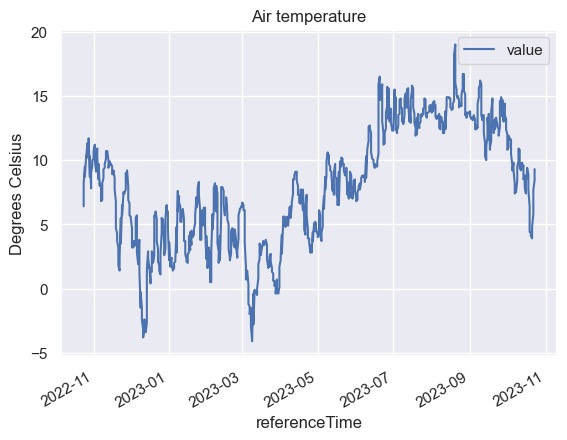

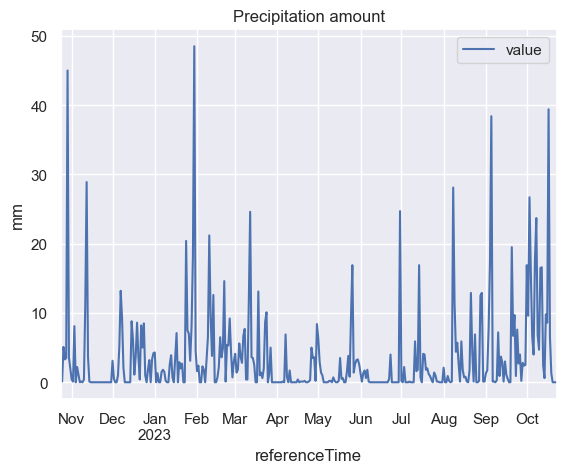

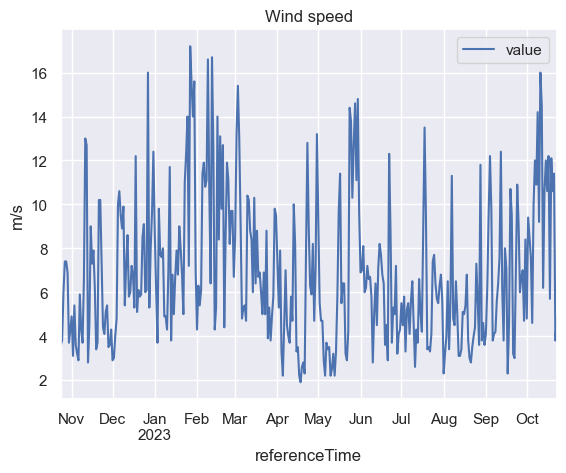

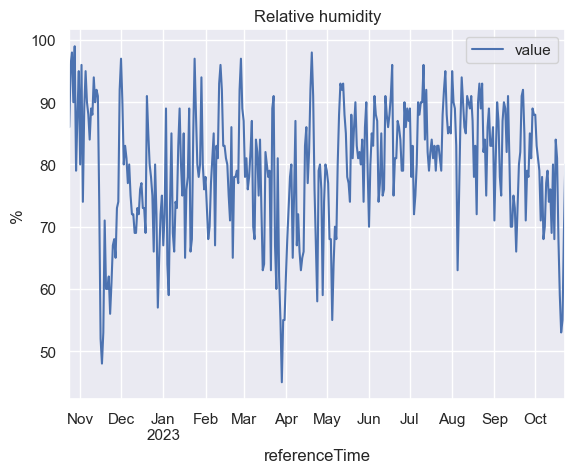

In [878]:
# plot values for each element based on time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# plot air_temperature
df_air_temperature = df[df['elementId'] == 'mean(air_temperature P1D)']
df_air_temperature = df_air_temperature[['referenceTime','value']]
df_air_temperature = df_air_temperature.set_index('referenceTime')
df_air_temperature.plot()
plt.title('Air temperature')
plt.ylabel('Degrees Celsius')
plt.show()

# plot precipitation_amount
df_precipitation_amount = df[df['elementId'] == 'sum(precipitation_amount P1D)']
df_precipitation_amount = df_precipitation_amount[['referenceTime','value']]
df_precipitation_amount = df_precipitation_amount.set_index('referenceTime')
df_precipitation_amount.plot()
plt.title('Precipitation amount')
plt.ylabel('mm')
plt.show()

# plot wind_speed
df_wind_speed = df[df['elementId'] == 'mean(wind_speed P1D)']
df_wind_speed = df_wind_speed[['referenceTime','value']]
df_wind_speed = df_wind_speed.set_index('referenceTime')
df_wind_speed.plot()
plt.title('Wind speed')
plt.ylabel('m/s')
plt.show()

# plot relative_humidity
df_relative_humidity = df[df['elementId'] == 'mean(relative_humidity P1D)']
df_relative_humidity = df_relative_humidity[['referenceTime','value']]
df_relative_humidity = df_relative_humidity.set_index('referenceTime')
df_relative_humidity.plot()
plt.title('Relative humidity')
plt.ylabel('%')
plt.show()




In [879]:
df.columns

Index(['sourceId', 'referenceTime', 'elementId', 'value', 'unit',
       'timeOffset'],
      dtype='object')

In [880]:
# Convert all column names to lower case
df.columns = df.columns.str.lower()

# make df to csv
df.to_csv('Data/weather.csv', index=False)

In [881]:
df.columns

Index(['sourceid', 'referencetime', 'elementid', 'value', 'unit',
       'timeoffset'],
      dtype='object')

<h2>Connecting to Cassandra Cluster</h2>

In [882]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [883]:
# Creating a keyspace
session.execute("CREATE KEYSPACE IF NOT EXISTS fish_keyspace WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

In [884]:
# set keyspace
session.set_keyspace('fish_keyspace')

In [885]:
# Drop the table if it already exists
session.execute("DROP TABLE IF EXISTS fish_keyspace.weather_table;") 

# Create a new table with primary keys
session.execute("""
   CREATE TABLE IF NOT EXISTS weather_table (
    sourceid TEXT,
    elementid TEXT,
    value DOUBLE,
    unit TEXT,
    timeoffset TEXT,
    referencetime DATE,
    PRIMARY KEY (elementid, timeoffset, referencetime)
);
""")


<h2>From Pandas dataframe to Spark dataframe</h2>

In [886]:
import os
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-20"
# If you are using environments in Python, you can set the environment variables like this:
os.environ["PYSPARK_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
#os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
# Set the Hadoop version to the one you are using, e.g., none:
#os.environ["PYSPARK_HADOOP_VERSION"] = "without"

In [887]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()
# Some warnings are to be expected.

In [888]:
# Read the data from the csv files
weather_data = spark.read.csv('Data/weather.csv', header=True, inferSchema=True)

In [889]:
# Write the data to Cassandra
keyspace = "fish_keyspace"
table = "weather_table"

weather_data.write \
    .format("org.apache.spark.sql.cassandra") \
    .option("table", table) \
    .option("keyspace", keyspace) \
    .mode("append").save()

In [890]:
# Read from Cassandra - fish_table_year
df_weather = spark.read.format("org.apache.spark.sql.cassandra").options(table="weather_table", keyspace="fish_keyspace").load()
df_weather.show()

+--------------------+----------+-------------+---------+----+-----+
|           elementid|timeoffset|referencetime| sourceid|unit|value|
+--------------------+----------+-------------+---------+----+-----+
|mean(air_temperat...|      PT0H|   2022-10-24|SN65310:0|degC|  8.2|
|mean(air_temperat...|      PT0H|   2022-10-25|SN65310:0|degC|  9.5|
|mean(air_temperat...|      PT0H|   2022-10-26|SN65310:0|degC| 10.3|
|mean(air_temperat...|      PT0H|   2022-10-27|SN65310:0|degC| 11.3|
|mean(air_temperat...|      PT0H|   2022-10-28|SN65310:0|degC| 10.8|
|mean(air_temperat...|      PT0H|   2022-10-29|SN65310:0|degC|  8.7|
|mean(air_temperat...|      PT0H|   2022-10-30|SN65310:0|degC|  9.0|
|mean(air_temperat...|      PT0H|   2022-10-31|SN65310:0|degC| 10.0|
|mean(air_temperat...|      PT0H|   2022-11-01|SN65310:0|degC| 10.7|
|mean(air_temperat...|      PT0H|   2022-11-02|SN65310:0|degC| 10.0|
|mean(air_temperat...|      PT0H|   2022-11-03|SN65310:0|degC| 10.3|
|mean(air_temperat...|      PT0H| 

In [891]:
# make a pandas dataframe
df_weather = df_weather.toPandas()
df_weather.head(10)




,elementid,timeoffset,referencetime,sourceid,unit,value
0,sum(precipitation_amount P1D),PT6H,2022-10-24,SN65370:0,mm,2.1
1,sum(precipitation_amount P1D),PT6H,2022-10-25,SN65370:0,mm,0.1
2,sum(precipitation_amount P1D),PT6H,2022-10-26,SN65370:0,mm,5.1
3,sum(precipitation_amount P1D),PT6H,2022-10-27,SN65370:0,mm,3.3
4,sum(precipitation_amount P1D),PT6H,2022-10-28,SN65370:0,mm,3.5
5,sum(precipitation_amount P1D),PT6H,2022-10-29,SN65370:0,mm,45.0
6,sum(precipitation_amount P1D),PT6H,2022-10-30,SN65370:0,mm,3.6
7,sum(precipitation_amount P1D),PT6H,2022-10-31,SN65370:0,mm,2.0
8,sum(precipitation_amount P1D),PT6H,2022-11-01,SN65370:0,mm,0.4
9,sum(precipitation_amount P1D),PT6H,2022-11-02,SN65370:0,mm,0.1


In [892]:
# get the first date in the week
df_weather['referencetime'] = pd.to_datetime(df_weather['referencetime'])
df_weather['week'] = df_weather['referencetime'].dt.isocalendar().week
df_weather['year'] = df_weather['referencetime'].dt.isocalendar().year


df_weather.head(10)

,elementid,timeoffset,referencetime,sourceid,unit,value,week,year
0,sum(precipitation_amount P1D),PT6H,2022-10-24,SN65370:0,mm,2.1,43,2022
1,sum(precipitation_amount P1D),PT6H,2022-10-25,SN65370:0,mm,0.1,43,2022
2,sum(precipitation_amount P1D),PT6H,2022-10-26,SN65370:0,mm,5.1,43,2022
3,sum(precipitation_amount P1D),PT6H,2022-10-27,SN65370:0,mm,3.3,43,2022
4,sum(precipitation_amount P1D),PT6H,2022-10-28,SN65370:0,mm,3.5,43,2022
5,sum(precipitation_amount P1D),PT6H,2022-10-29,SN65370:0,mm,45.0,43,2022
6,sum(precipitation_amount P1D),PT6H,2022-10-30,SN65370:0,mm,3.6,43,2022
7,sum(precipitation_amount P1D),PT6H,2022-10-31,SN65370:0,mm,2.0,44,2022
8,sum(precipitation_amount P1D),PT6H,2022-11-01,SN65370:0,mm,0.4,44,2022
9,sum(precipitation_amount P1D),PT6H,2022-11-02,SN65370:0,mm,0.1,44,2022


<h1>DEL 2

In [893]:
# read from Cassandra - fish_table_year 
lice_count_table = spark.read.format("org.apache.spark.sql.cassandra").options(table="lice_count_table", keyspace="fish_keyspace").load()


# turn the dataframes into pandas dataframes
lice_count_table = lice_count_table.toPandas()

# drop columns where all values are null or nan
lice_count_table = lice_count_table.dropna(axis=1, how='all')
lice_count_table

,year_week,avgadultfemalelice,avgmobilelice,avgstationarylice,localityname,specieslist,week,year
0,2023-01-30,0.06,0.24,0.02,Andholmen 1,"['Laks', 'Ørret', 'Regnbueørret']",5,2023
1,2023-06-05,0.05,0.98,0.20,Andholmen 1,"['Laks', 'Ørret', 'Regnbueørret']",23,2023
2,2023-06-19,0.09,0.60,0.06,Andholmen 1,"['Laks', 'Ørret', 'Regnbueørret']",25,2023
3,2022-11-21,0.01,0.15,0.00,Andholmen 1,"['Laks', 'Ørret', 'Regnbueørret']",47,2022
4,2023-08-07,0.11,0.21,0.00,Andholmen 1,"['Laks', 'Ørret', 'Regnbueørret']",32,2023
5,2023-05-15,0.02,0.26,0.02,Andholmen 1,"['Laks', 'Ørret', 'Regnbueørret']",20,2023
6,2023-01-02,0.15,0.38,0.03,Andholmen 1,"['Laks', 'Ørret', 'Regnbueørret']",1,2023
7,2023-03-27,0.03,0.10,0.00,Andholmen 1,"['Laks', 'Ørret', 'Regnbueørret']",13,2023
8,2023-01-09,0.08,0.48,0.01,Andholmen 1,"['Laks', 'Ørret', 'Regnbueørret']",2,2023
9,2023-10-02,0.11,0.15,0.00,Andholmen 1,"['Laks', 'Ørret', 'Regnbueørret']",40,2023


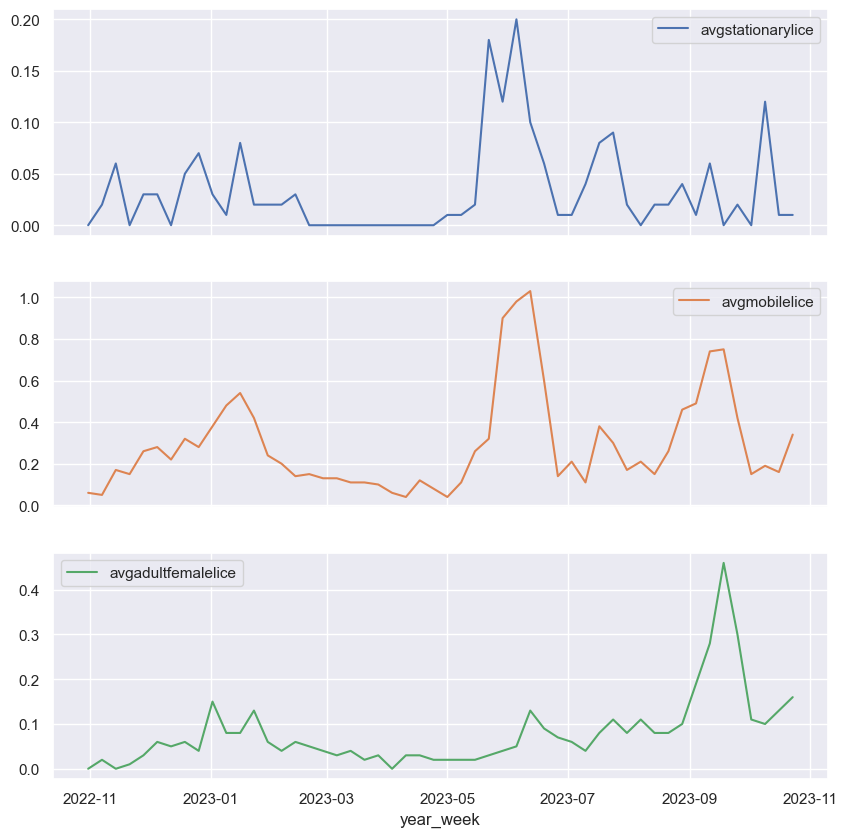

In [894]:
# plot avgstationarylice, avgmobilelice, avgfemalelice based on year_week, in 3 subplots
lice_count_table_plot = lice_count_table[['year_week','avgstationarylice','avgmobilelice','avgadultfemalelice']]
lice_count_table_plot = lice_count_table_plot.set_index('year_week')
lice_count_table_plot.plot(subplots=True, figsize=(10,10))

plt.show()


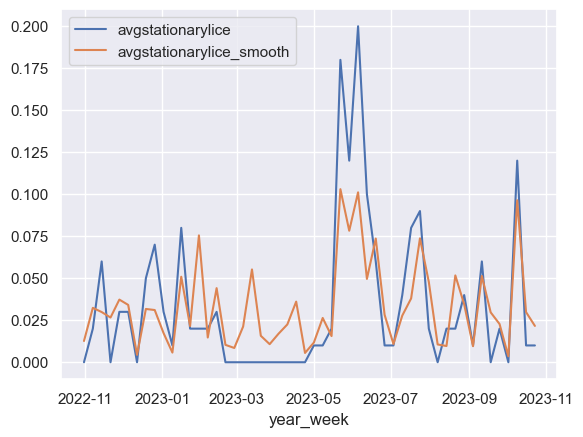

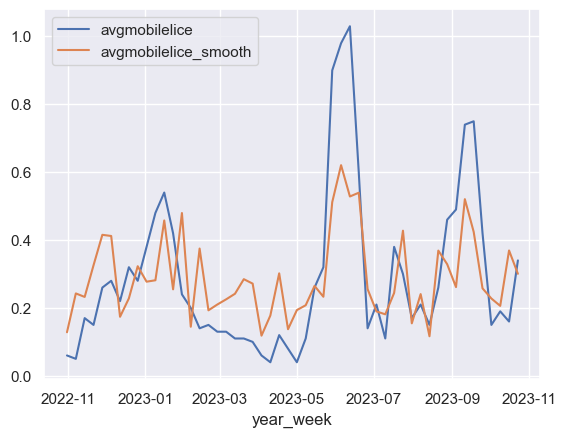

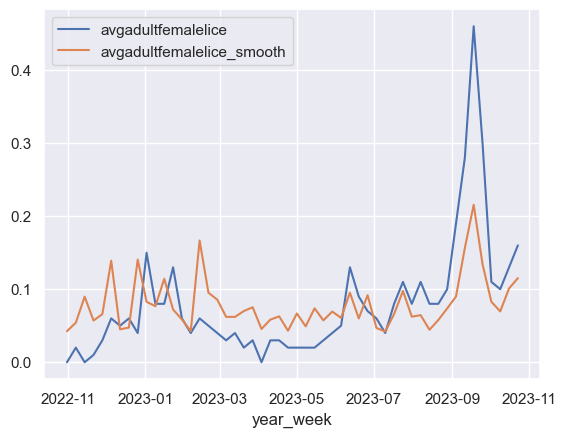

In [895]:
# do the same with gaussian filter
from scipy.ndimage import gaussian_filter1d
lice_count_table_plot = lice_count_table_plot.reset_index()

lice_count_table_plot['avgstationarylice_smooth'] = gaussian_filter1d(lice_count_table_plot['avgstationarylice'], sigma=1)
lice_count_table_plot['avgmobilelice_smooth'] = gaussian_filter1d(lice_count_table_plot['avgmobilelice'], sigma=1)
lice_count_table_plot['avgadultfemalelice_smooth'] = gaussian_filter1d(lice_count_table_plot['avgadultfemalelice'], sigma=1)

# do the same for lice_count_table

lice_count_table['avgstationarylice_smooth'] = gaussian_filter1d(lice_count_table['avgstationarylice'], sigma=1)    
lice_count_table['avgmobilelice_smooth'] = gaussian_filter1d(lice_count_table['avgmobilelice'], sigma=1)
lice_count_table['avgadultfemalelice_smooth'] = gaussian_filter1d(lice_count_table['avgadultfemalelice'], sigma=1)




lice_count_table_plot = lice_count_table_plot.set_index('year_week')
lice_count_table_plot[['avgstationarylice','avgstationarylice_smooth']].plot()
lice_count_table_plot[['avgmobilelice','avgmobilelice_smooth']].plot()
lice_count_table_plot[['avgadultfemalelice','avgadultfemalelice_smooth']].plot()
plt.show()






In [896]:
lice_count_table_plot.head()

,avgstationarylice,avgmobilelice,avgadultfemalelice,avgstationarylice_smooth,avgmobilelice_smooth,avgadultfemalelice_smooth
year_week,,,,,,
2023-01-30,0.02,0.24,0.06,0.075516,0.479630,0.058571
2023-06-05,0.20,0.98,0.05,0.101123,0.620666,0.060746
2023-06-19,0.06,0.60,0.09,0.073619,0.539488,0.059983
2022-11-21,0.00,0.15,0.01,0.026621,0.325581,0.057106
2023-08-07,0.00,0.21,0.11,0.010589,0.240780,0.064474


In [897]:
# Compute robust means and robust covariance for the raw data.
from sklearn.covariance import MinCovDet
robust_cov = MinCovDet().fit(lice_count_table_plot[['avgstationarylice','avgmobilelice','avgadultfemalelice']])
robust_mean = robust_cov.location_
robust_covariance = robust_cov.covariance_

# print the results
print('Robust location:')
print(robust_mean)
print('\nRobust covariance matrix:')
print(robust_covariance)





Robust location:
[0.01314286 0.17657143 0.05371429]

Robust covariance matrix:
[[0.00019869 0.00088506 0.00017404]
 [0.00088506 0.0105311  0.00251845]
 [0.00017404 0.00251845 0.00142906]]


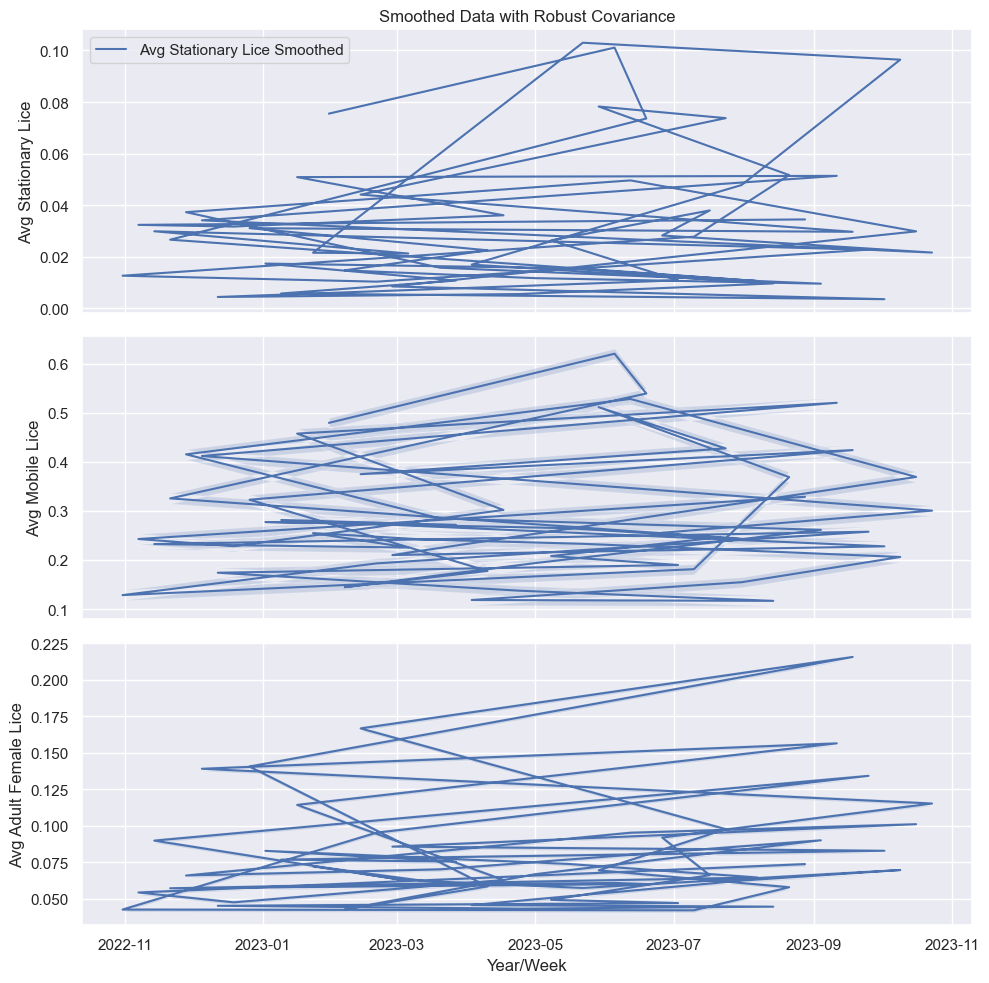

In [898]:
import matplotlib.pyplot as plt

# Assuming lice_count_table_plot, avgstationarylice_smooth, avgmobilelice_smooth, and avgadultfemalelice_smooth are defined

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Plot the smoothed data on the first subplot
axes[0].plot(lice_count_table_plot.index, lice_count_table_plot['avgstationarylice_smooth'], label='Avg Stationary Lice Smoothed')
axes[0].fill_between(lice_count_table_plot.index, lice_count_table_plot['avgstationarylice_smooth'] - robust_covariance[0, 0], lice_count_table_plot['avgstationarylice_smooth'] + robust_covariance[0, 0], alpha=0.2)
axes[0].set_ylabel('Avg Stationary Lice')

# Plot the smoothed data on the second subplot
axes[1].plot(lice_count_table_plot.index, lice_count_table_plot['avgmobilelice_smooth'], label='Avg Mobile Lice Smoothed')
axes[1].fill_between(lice_count_table_plot.index, lice_count_table_plot['avgmobilelice_smooth'] - robust_covariance[1, 1], lice_count_table_plot['avgmobilelice_smooth'] + robust_covariance[1, 1], alpha=0.2)
axes[1].set_ylabel('Avg Mobile Lice')

# Plot the smoothed data on the third subplot
axes[2].plot(lice_count_table_plot.index, lice_count_table_plot['avgadultfemalelice_smooth'], label='Avg Adult Female Lice Smoothed')
axes[2].fill_between(lice_count_table_plot.index, lice_count_table_plot['avgadultfemalelice_smooth'] - robust_covariance[2, 2], lice_count_table_plot['avgadultfemalelice_smooth'] + robust_covariance[2, 2], alpha=0.2)
axes[2].set_xlabel('Year/Week')
axes[2].set_ylabel('Avg Adult Female Lice')

# Add labels and legend to the first subplot
axes[0].set_title('Smoothed Data with Robust Covariance')
axes[0].legend()

# Tight layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [899]:
df_weather.dtypes


elementid                object
timeoffset               object
referencetime    datetime64[ns]
sourceid                 object
unit                     object
value                   float64
week                     UInt32
year                     UInt32
dtype: object

In [900]:
# sync the dataframe lice_table_year_plot with weather_table
df_weather.head(10)


,elementid,timeoffset,referencetime,sourceid,unit,value,week,year
0,sum(precipitation_amount P1D),PT6H,2022-10-24,SN65370:0,mm,2.1,43,2022
1,sum(precipitation_amount P1D),PT6H,2022-10-25,SN65370:0,mm,0.1,43,2022
2,sum(precipitation_amount P1D),PT6H,2022-10-26,SN65370:0,mm,5.1,43,2022
3,sum(precipitation_amount P1D),PT6H,2022-10-27,SN65370:0,mm,3.3,43,2022
4,sum(precipitation_amount P1D),PT6H,2022-10-28,SN65370:0,mm,3.5,43,2022
5,sum(precipitation_amount P1D),PT6H,2022-10-29,SN65370:0,mm,45.0,43,2022
6,sum(precipitation_amount P1D),PT6H,2022-10-30,SN65370:0,mm,3.6,43,2022
7,sum(precipitation_amount P1D),PT6H,2022-10-31,SN65370:0,mm,2.0,44,2022
8,sum(precipitation_amount P1D),PT6H,2022-11-01,SN65370:0,mm,0.4,44,2022
9,sum(precipitation_amount P1D),PT6H,2022-11-02,SN65370:0,mm,0.1,44,2022


In [901]:
# combine the year and week columns to one column
df_weather['year_week'] = df_weather['year'].astype(str) + '_' + df_weather['week'].astype(str)






In [902]:
df_weather.shape


(1825, 9)

In [903]:
# gruop by referencetime
df_weather = df_weather.groupby(['referencetime','elementid', 'week', 'year','unit', 'sourceid', 'year_week'] )
df_weather = df_weather['value'].mean()


In [904]:
df_weather.head(10)

referencetime  elementid                      week  year  unit     sourceid   year_week
2022-10-24     mean(air_temperature P1D)      43    2022  degC     SN65310:0  2022_43       7.30
               mean(relative_humidity P1D)    43    2022  percent  SN65310:0  2022_43      86.00
               mean(wind_speed P1D)           43    2022  m/s      SN65310:0  2022_43       3.60
               sum(precipitation_amount P1D)  43    2022  mm       SN65370:0  2022_43       2.10
2022-10-25     mean(air_temperature P1D)      43    2022  degC     SN65310:0  2022_43       9.10
               mean(relative_humidity P1D)    43    2022  percent  SN65310:0  2022_43      96.00
               mean(wind_speed P1D)           43    2022  m/s      SN65310:0  2022_43       3.80
               sum(precipitation_amount P1D)  43    2022  mm       SN65370:0  2022_43       0.10
2022-10-26     mean(air_temperature P1D)      43    2022  degC     SN65310:0  2022_43      10.25
               mean(relative_humidity P

In [905]:
df_weather = df_weather.reset_index()

In [906]:
df_weather.head(10)

,referencetime,elementid,week,year,unit,sourceid,year_week,value
0,2022-10-24,mean(air_temperature P1D),43,2022,degC,SN65310:0,2022_43,7.30
1,2022-10-24,mean(relative_humidity P1D),43,2022,percent,SN65310:0,2022_43,86.00
2,2022-10-24,mean(wind_speed P1D),43,2022,m/s,SN65310:0,2022_43,3.60
3,2022-10-24,sum(precipitation_amount P1D),43,2022,mm,SN65370:0,2022_43,2.10
4,2022-10-25,mean(air_temperature P1D),43,2022,degC,SN65310:0,2022_43,9.10
5,2022-10-25,mean(relative_humidity P1D),43,2022,percent,SN65310:0,2022_43,96.00
6,2022-10-25,mean(wind_speed P1D),43,2022,m/s,SN65310:0,2022_43,3.80
7,2022-10-25,sum(precipitation_amount P1D),43,2022,mm,SN65370:0,2022_43,0.10
8,2022-10-26,mean(air_temperature P1D),43,2022,degC,SN65310:0,2022_43,10.25
9,2022-10-26,mean(relative_humidity P1D),43,2022,percent,SN65310:0,2022_43,98.00


In [907]:
df_weather.shape

(1460, 8)

elementid
mean(air_temperature P1D)        365
mean(relative_humidity P1D)      365
mean(wind_speed P1D)             365
sum(precipitation_amount P1D)    365
Name: count, dtype: int64